# Phase equilibria

Two basic approaches are implemented in teqp:

* Iterative calculations given guess values
* Tracing along iso-curves (constant temperature, etc.) powered by the isochoric thermodynamics formalism

In [42]:
import teqp
import numpy as np
import pandas
import matplotlib.pyplot as plt
teqp.__version__

'0.9.4.dev0'

## Iterative Phase Equilibria

### Pure fluid

For a pure fluid, phase equilibrium between two phases is defined by equating the pressures and Gibbs energies in the two phases. This represents a 2D non-linear rootfinding problem. Newton's method can be used for the rootfinding, and in teqp, automatic differentiation is used to obtain the necessary Jacobian matrix so the implementation is quite efficient.

The method requires guess values, which are the densities of the liquid and vapor densities.  In some cases, ancillary or superancillary equations have been developed which provide curves of guess densities as a function of temperature.

For a pure fluid, you can use the ``pure_VLE_T`` method to carry out the iteration.

In [43]:
# Instantiate the model
model = teqp.canonical_PR([300], [4e6], [0.1])

T = 250 # [K], Temperature to be used

# Here we use the superancillary to get guess values (actually these are more 
# accurate than the results we will obtain from iteration!)
rhoL0, rhoV0 = model.superanc_rhoLV(T)
display('guess:', [rhoL0, rhoV0])

# Carry out the iteration, return the liquid and vapor densities
# The guess values are perturbed to make sure the iteration is actually
# changing the values
teqp.pure_VLE_T(model, T, rhoL0*0.98, rhoV0*1.02, 10)

'guess:'

[12735.311173407898, 752.4082303122791]

array([12735.31117341,   752.40823031])

### Binary Mixture

For a binary mixture, the approach is roughly similar to that of a pure fluid. The pressure is equated between phases, and the chemical potentials of each component in each phase are forced to be the same. 

Again, the user is required to provide guess values, in this case molar concentrations in each phase, and a Newton method is implemented to solve for the phase equilibrium. The analytical Jacobian is obtained from automatic differentiation.

The ``mix_VLE_Tx`` function is the binary mixture analog to ``pure_VLE_T`` for pure fluids.

In [44]:
zA = np.array([0.01, 0.99])
model = teqp.canonical_PR([300,310], [4e6,4.5e6], [0.1, 0.2])
model1 = teqp.canonical_PR([300], [4e6], [0.1])
T = 273.0 # [K]
# start off at pure of the first component
rhoL0, rhoV0 = model1.superanc_rhoLV(T)

# then we shift to the given composition in the first phase
# to get guess values
rhovecA0 = rhoL0*zA
rhovecB0 = rhoV0*zA

# carry out the iteration
code, rhovecA, rhovecB = teqp.mix_VLE_Tx(model, T, rhovecA0, rhovecB0, zA, 
     1e-10, 1e-10, 1e-10, 1e-10,  # stopping conditions
     10 # maximum number of iterations
    )
code, rhovecA, rhovecB

(<VLE_return_code.xtol_satisfied: 1>,
 array([  128.66049209, 12737.38871682]),
 array([  12.91868229, 1133.77242677]))

You can (and should) check the value of the return code to make sure the iteration succeeded. Do not rely on the numerical value of the enumerated return codes!

# Tracing

When it comes to mixture thermodynamics, as soon as you add another component to a pure component to form a binary mixture, the complexity of the thermodynamics entirely changes. For that reason, mixture iterative calculations for mixtures are orders of magnitude more difficult to carry out.  Asymmetric mixtures can do all sorts of interesting things that are entirely unlike those of pure fluids, and the algorithms are therefore much, much more complicated.  Formulating phase equilibrium problems for pure fluids is not much more complicated, but the most challenging aspect is to obtain good guess values from which to start an iterative routine

Ulrich Deiters and Ian Bell have developed a number of algorithms for tracing phase equilibrium solutions as the solution of ordinary differential equations rather than carrying out iterative routines for a given state point.  The advantage of the tracing calculations is that they can be often initiated at a state point that is entirely known, perhaps the pure fluid endpoint for a subcritical isotherm.

The C++ implementation returns a string in JSON format, which can be conveniently operated upon, for instance after converting the returned data structure to a ``pandas.DataFrame``.  A simple example of plotting a subcritical isotherm for a "boring" mixture is presented here:

In [47]:
model = teqp.canonical_PR([300,310], [4e6,4.5e6], [0.1, 0.2])
model1 = teqp.canonical_PR([300], [4e6], [0.1])
T = 273.0 # [K]
rhoL0, rhoV0 = model1.superanc_rhoLV(T) # start off at pure of the first component
j = teqp.trace_VLE_isotherm_binary(model, T, np.array([rhoL0, 0]), np.array([rhoV0, 0]))
display(str(j)[0:100]+'...') # The first few bits of the data
df = pandas.DataFrame(j) # Now as a data frame
df.head(3)

"[{'T / K': 273.0, 'c': -1.0, 'drho/dt': [-0.618312383229212, 0.7690760182230469, -0.1277526773161415..."

,T / K,c,drho/dt,dt,pL / Pa,pV / Pa,rhoL / mol/m^3,rhoV / mol/m^3,t,xL_0 / mole frac.,xV_0 / mole frac.
0,273.0,-1.0,"[-0.618312383229212, 0.7690760182230469, -0.12...",0.000010,2.203397e+06,2.203397e+06,"[10697.985891540735, 0.0]","[1504.6120879290752, 0.0]",0.000000,1.0,1.0
1,273.0,-1.0,"[-0.6183123817120353, 0.7690760162922189, -0.1...",0.000045,2.203397e+06,2.203397e+06,"[10697.985885357639, 7.690760309421386e-06]","[1504.6120866515366, 9.945415375682985e-07]",0.000010,1.0,1.0
2,273.0,-1.0,"[-0.6183123827116788, 0.7690760173388914, -0.1...",0.000203,2.203397e+06,2.203397e+06,"[10697.98585753358, 4.229918121248511e-05]","[1504.6120809026731, 5.469978386095445e-06]",0.000055,1.0,1.0


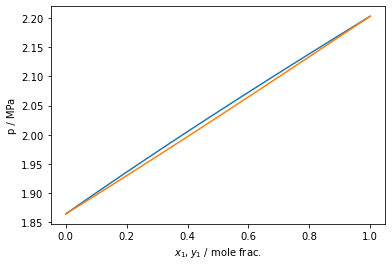

In [49]:
plt.plot(df['xL_0 / mole frac.'], df['pL / Pa']/1e6)
plt.plot(df['xV_0 / mole frac.'], df['pL / Pa']/1e6)
plt.gca().set(xlabel='$x_1,y_1$ / mole frac.', ylabel='p / MPa')
plt.show()

Isn't that exciting!

You can also provide an optional set of flags to the function to control other behaviors of the function, and switch between simple Euler and adaptive RK45 integration (the default)

Supercritical isotherms should work approximately in the same manner

In [ ]:
Tc_K = [190.564, 154.581]
pc_Pa = [4599200, 5042800]
acentric = [0.011, 0.022]
model = teqp.canonical_PR(Tc_K, pc_Pa, acentric)
model1 = teqp.canonical_PR([Tc_K[0]], [pc_Pa[0]], [acentric[0]])
T = 170.0 # [K] # Note: above Tc of the second component
rhoL0, rhoV0 = model1.superanc_rhoLV(T) # start off at pure of the first component
j = teqp.trace_VLE_isotherm_binary(model, T, np.array([rhoL0, 0]), np.array([rhoV0, 0]))
df = pandas.DataFrame(j) # Now as a data frame
plt.plot(df['xL_0 / mole frac.'], df['pL / Pa']/1e6)
plt.plot(df['xV_0 / mole frac.'], df['pL / Pa']/1e6)
plt.gca().set(xlabel='$x_1,y_1$ / mole frac.', ylabel='p / MPa')
plt.show()